In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [2]:
N = 10

In [3]:
init_random = np.random.random((N,N,N)) #Gives a random number from 0.0 to 1.0 open
lattice_n = np.zeros((N,N,N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N,N)) #Gives a random number from 0.0 to 1.0 open
lattice_p = np.zeros((N,N,N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

In [4]:
def get_energy(s):
    m, n, l = np.shape(s)
    E = 0.0
    
    for j in (0,n-2): 
        for i in (0,m-2):
            for k in (0,l-2):
                E -= s[i,j,k]*s[i+1,j,k] - s[i,j,k]*s[i,j+1,k] - s[i,j,k]*s[i,j,k+1]
    return E

In [5]:
#@numba.njit("UniTuple(f8[:],2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        z = np.random.randint(0,N)
        spin_i = spin_arr[x,y,z] #Initial spin
        spin_f = spin_i*(-1) #Proposed spin flip
        
        #Compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y,z]
            E_f += -spin_f*spin_arr[x-1,y,z]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y,z]
            E_f += -spin_f*spin_arr[x+1,y,z]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1,z]
            E_f += -spin_f*spin_arr[x,y-1,z]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1,z]
            E_f += -spin_f*spin_arr[x,y+1,z]
        if z>0:
            E_i += -spin_i*spin_arr[x,y,z-1]
            E_f += -spin_f*spin_arr[x,y,z-1]
        if z<N-1:
            E_i += -spin_i*spin_arr[x,y,z+1]
            E_f += -spin_f*spin_arr[x,y,z+1]
            
        dE = E_f - E_i
        if (dE>0) and (np.random.random()<np.exp(-BJ*dE)):
            spin_arr[x,y,z]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y,z]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
        
    return net_spins, net_energy

In [ ]:
spins, energies = metropolis(lattice_n, 5000000, 0.001 , get_energy(lattice_n))

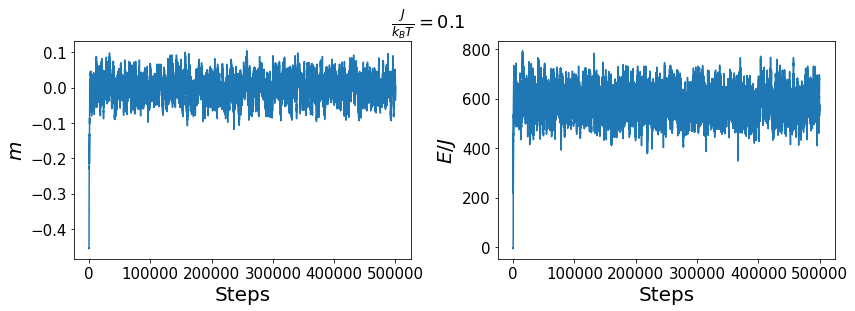

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/(N*N*N))

ax.set_xlabel('Steps', fontsize='20')
#ax.set_xlabel("Steps [$10^{6}]$")
#ax.tick_params(length=10, width=1)
ax.set_ylabel(r'$m$', fontsize='20')
ax.tick_params(labelsize=15)

ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Steps', fontsize='20')
ax.set_ylabel(r'$E/J$', fontsize='20')
ax.tick_params(labelsize=15)
fig.tight_layout()
fig.suptitle(r'$\frac{J}{k_B T}=0.1$', y=1.07, size=18)
plt.show()